In [1]:
#étape 1-
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install sktime
!pip install numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 15.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np

from sktime.classification.dictionary_based import MUSE
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.kernel_based import Arsenal
from sktime.classification.interval_based import DrCIF

In [3]:
import sources.splitter as splitter

In [4]:
splitter.recompose("signes.csv")

./csv/signes.csv


In [12]:
# Charger le dataframe
# df_signe = pd.read_table("/content/drive/MyDrive/Capgemini/csv/signes_ml.csv", sep=",", encoding='utf-8', index_col=[0,1])
df_signe = pd.read_table("./csv/signes.csv", sep=",", encoding='utf-8', index_col=[0,1])

# Supprimme les NaN
df_signe = df_signe.dropna()

In [13]:
df_signe.head()

MAR  EAR_left  EAR_right  EAR_mean     HOP_gd    HOP_hb  \
instance frame                                                                 
0        0      0.304471  0.185283   0.224274  0.204779  90.034640  2.853962   
         1      0.302388  0.293654   0.361263  0.327459  90.029065  2.758461   
         2      0.308048  0.267476   0.338525  0.303000  90.031310  3.453699   
         3      0.314971  0.267631   0.336078  0.301855  90.029595  3.279016   
         4      0.328905  0.262299   0.334176  0.298237  90.029725  3.619524   

                EBR  PERCLOS  classe  
instance frame                        
0        0        0      0.0       2  
         1        0      0.0       2  
         2        0      0.0       2  
         3        0      0.0       2  
         4        0      0.0       2

In [14]:
test = df_signe["classe"]
test[0]

frame
0      2
1      2
2      2
3      2
4      2
      ..
870    2
871    2
872    2
873    2
874    2
Name: classe, Length: 875, dtype: int64

In [15]:
colonnes_X = ["MAR", "EAR_mean", "EBR", "PERCLOS"] # , "EAR_left", "EAR_right", "EBR", "PERCLOS", "HOP_gd", "HOP_hb"

X = df_signe[colonnes_X]
y = [df_signe["classe"][i][0] for i in range(0, df_signe.shape[0]//875)]

In [16]:
# transformation des données en numpy
X = X.to_numpy()
X = X.reshape(X.shape[0]//875, len(colonnes_X), 875)

In [17]:
y = np.array(y)

In [18]:
# Séparation des données en ensemble d'entraînement et ensemble de test
# L'argument stratify de la fonction train_test_split() garantit que la distribution des classes dans l'ensemble d'entraînement et l'ensemble de test est similaire à celle de l'ensemble complet.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Liste des classifieurs à tester avec leurs acronymes respectifs

classifieurs = {
    # 'RFt': RandomForestClassifier(random_state=42),
    # 'SVM': SVC(probability=True)  # Activer la prédiction des probabilités
    # "MUSE" : MUSE(),
    # "Arsenal" : Arsenal(),
    "Drcif" : DrCIF()
}

# Dictionnaires pour stocker les performances de chaque classifieur
resultats_precision = {}
resultats_sensibilite = {}
resultats_specificite = {}
resultats_fiabilite = {}

for nom_clf, clf in classifieurs.items():
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn = cm[0, 0], cm[0, 1], cm[1, 0]
    tp = cm[1, 1] if cm.shape[0] == 2 else cm[1, 1:].sum()

    # Calcul des métriques
    precision = accuracy_score(y_test, y_pred)
    sensibilite = recall_score(y_test, y_pred, average='macro')
    specificite = tn / (tn + fp)
    fiabilite = (tp + tn) / (tp + tn + fp + fn)

    # Stockage des résultats
    resultats_precision[nom_clf] = precision
    resultats_sensibilite[nom_clf] = sensibilite
    resultats_specificite[nom_clf] = specificite
    resultats_fiabilite[nom_clf] = fiabilite

    # Affichage de la matrice de confusion avec annotations
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False)


    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de confusion - {nom_clf}')
    plt.show()

    print(f'Précision pour {nom_clf}: {precision}')
    print(f'Sensibilité pour {nom_clf}: {sensibilite}')
    print(f'Spécificité pour {nom_clf}: {specificite}')
    print(f'Fiabilité pour {nom_clf}: {fiabilite}')

print("Terminé !")

# Tracé des métriques pour chaque classifieur
plt.figure(figsize=(10, 6))

# Tracé de la précision
plt.subplot(2, 2, 1)
plt.bar(resultats_precision.keys(), resultats_precision.values(), color='skyblue')
plt.title('Précision')
plt.ylabel('Score de précision')

# Tracé de la sensibilité
plt.subplot(2, 2, 2)
plt.bar(resultats_sensibilite.keys(), resultats_sensibilite.values(), color='salmon')
plt.title('Sensibilité')
plt.ylabel('Score de sensibilité')

# Tracé de la spécificité
plt.subplot(2, 2, 3)
plt.bar(resultats_specificite.keys(), resultats_specificite.values(), color='lightgreen')
plt.title('Spécificité')
plt.ylabel('Score de spécificité')

# Tracé de la fiabilité
plt.subplot(2, 2, 4)
plt.bar(resultats_fiabilite.keys(), resultats_fiabilite.values(), color='gold')
plt.title('Fiabilité')
plt.ylabel('Score de fiabilité')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

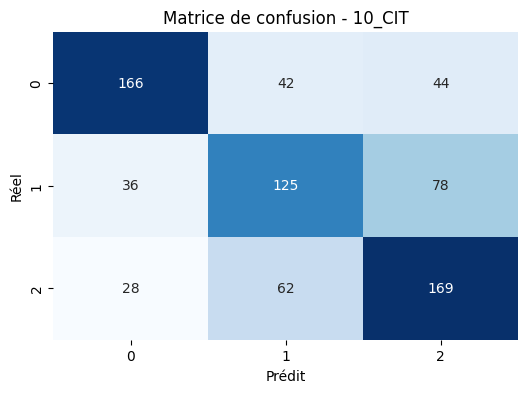

Précision pour 10_CIT: 0.6133333333333333
Sensibilité pour 10_CIT: 0.6114174545136889
Spécificité pour 10_CIT: 0.7980769230769231
Fiabilité pour 10_CIT: 0.825503355704698


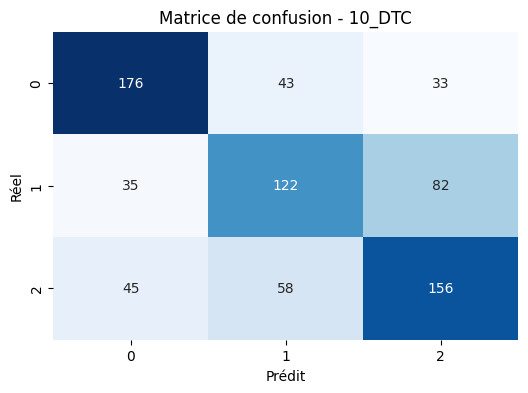

Précision pour 10_DTC: 0.6053333333333333
Sensibilité pour 10_DTC: 0.6037298505917753
Spécificité pour 10_DTC: 0.8036529680365296
Fiabilité pour 10_DTC: 0.8296943231441049


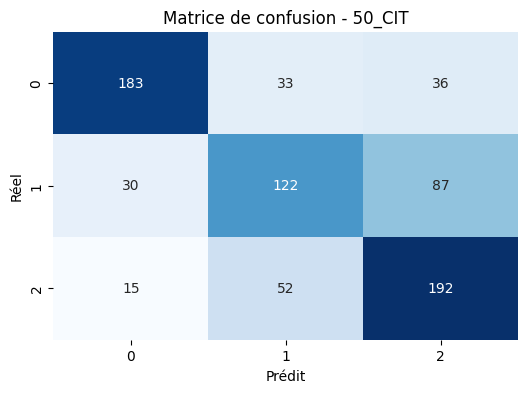

Précision pour 50_CIT: 0.6626666666666666
Sensibilité pour 50_CIT: 0.6593211561830808
Spécificité pour 50_CIT: 0.8472222222222222
Fiabilité pour 50_CIT: 0.8615384615384616


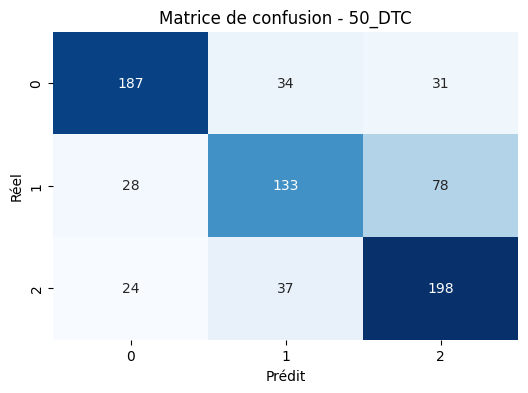

Précision pour 50_DTC: 0.6906666666666667
Sensibilité pour 50_DTC: 0.687675870730264
Spécificité pour 50_DTC: 0.8461538461538461
Fiabilité pour 50_DTC: 0.8652173913043478


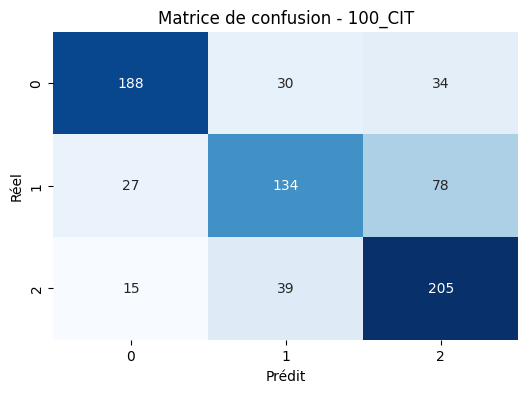

Précision pour 100_CIT: 0.7026666666666667
Sensibilité pour 100_CIT: 0.6994023312014944
Spécificité pour 100_CIT: 0.8623853211009175
Fiabilité pour 100_CIT: 0.87527352297593


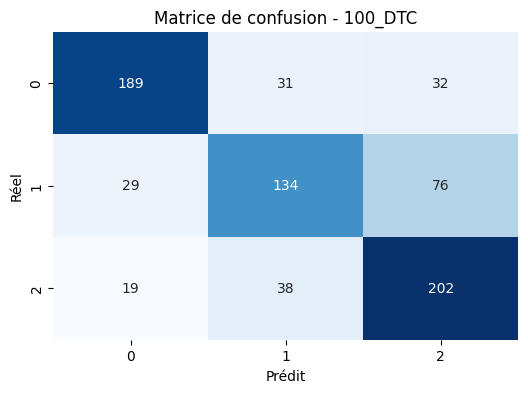

Précision pour 100_DTC: 0.7
Sensibilité pour 100_DTC: 0.6968640786632418
Spécificité pour 100_DTC: 0.8590909090909091
Fiabilité pour 100_DTC: 0.869281045751634


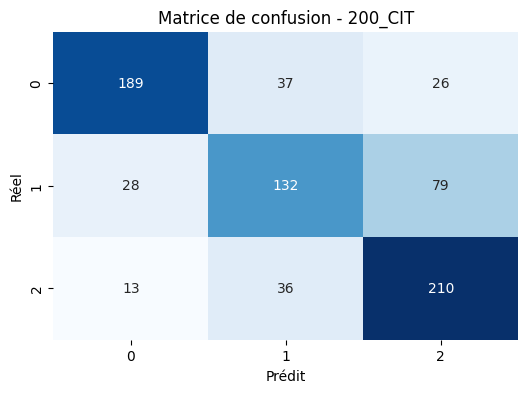

Précision pour 200_CIT: 0.708
Sensibilité pour 200_CIT: 0.7043706886803122
Spécificité pour 200_CIT: 0.8362831858407079
Fiabilité pour 200_CIT: 0.8602150537634409


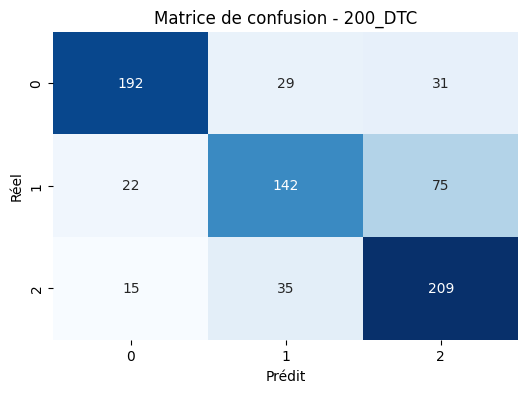

Précision pour 200_DTC: 0.724
Sensibilité pour 200_DTC: 0.7209989427562649
Spécificité pour 200_DTC: 0.8687782805429864
Fiabilité pour 200_DTC: 0.8891304347826087


KeyboardInterrupt: 

In [13]:
n_estimators = [10, 50, 100, 200, 300]
base_estimator = ['CIT', 'DTC']

# Dictionnaires pour stocker les performances de chaque classifieur
resultats_precision = {}
resultats_sensibilite = {}
resultats_specificite = {}
resultats_fiabilite = {}

for nest in n_estimators:
    for best in base_estimator:
        clf = DrCIF(n_estimators=nest, base_estimator=best, random_state=42, n_jobs=-1)
        index = f"{nest}_{best}"
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn = cm[0, 0], cm[0, 1], cm[1, 0]
        tp = cm[1, 1] if cm.shape[0] == 2 else cm[1, 1:].sum()

        # Calcul des métriques
        precision = accuracy_score(y_test, y_pred)
        sensibilite = recall_score(y_test, y_pred, average='macro')
        specificite = tn / (tn + fp)
        fiabilite = (tp + tn) / (tp + tn + fp + fn)

        # Stockage des résultats
        resultats_precision[index] = precision
        resultats_sensibilite[index] = sensibilite
        resultats_specificite[index] = specificite
        resultats_fiabilite[index] = fiabilite

        # Affichage de la matrice de confusion avec annotations
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)


        plt.xlabel('Prédit')
        plt.ylabel('Réel')
        plt.title(f'Matrice de confusion - {index}')
        plt.show()

        print(f'Précision pour {index}: {precision}')
        print(f'Sensibilité pour {index}: {sensibilite}')
        print(f'Spécificité pour {index}: {specificite}')
        print(f'Fiabilité pour {index}: {fiabilite}')

In [19]:
from sklearn.model_selection import GridSearchCV

In [ ]:
n_estimators = [10, 50, 100, 200, 300]
base_estimator = ['CIT', 'DTC']

clf = DrCIF(random_state=42, n_jobs=-1)
parameters = {'n_estimators': n_estimators, 'base_estimator': base_estimator}